In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
def sin(x,T=100) :
    return np.sin(2.0*np.pi*x/T)

In [16]:
def toy_problem(T=100,ampl=0.05) :
    x=np.arange(0,2*T+1)
    noise=ampl*np.random.uniform(low=-1,high=1,size=len(x))
    return sin(x)+noise

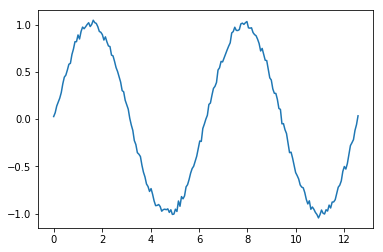

In [25]:
f=toy_problem(T=100,ampl=0.05)
x=np.arange(0,200+1)*(np.pi*4)/200
plt.plot(x,f)

In [26]:
length_of_sequence=2*100
maxlen=25

data=[]
target=[]
for i in range(0,length_of_sequence-maxlen+1) :
    data.append(f[i:(i+maxlen)])
    target.append(f[i+maxlen])

In [27]:
len(data)

176

In [28]:
type(data)

list

In [29]:
data[0]

array([0.02742331, 0.06773396, 0.13815552, 0.17878277, 0.22252936,
       0.28137126, 0.37389021, 0.44430409, 0.46603629, 0.51989227,
       0.58101543, 0.59117901, 0.6842647 , 0.74193121, 0.81978593,
       0.82038553, 0.89141821, 0.84888605, 0.92806504, 0.9749869 ,
       0.95733998, 0.978257  , 1.00221329, 1.02107824, 0.98037775])

In [30]:
data[0].shape

(25,)

In [31]:
X=np.array(data)
X.shape

(176, 25)

In [33]:
X=np.array(data).reshape(len(data),maxlen,1)
X.shape

(176, 25, 1)

In [36]:
Y=np.array(target).reshape(len(data),1)
Y.shape

(176, 1)

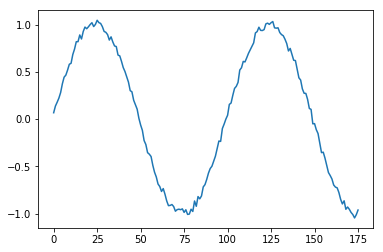

In [37]:
plt.plot(X[:,1,0])

In [38]:
from sklearn.model_selection import train_test_split

In [43]:
N_train=int(len(data)*0.9)
N_validation=len(data)-N_train

In [44]:
N_train+N_validation

176

In [45]:
X_train, X_validation, Y_train, Y_validation=train_test_split(X,Y,test_size=N_validation)

In [46]:
X_train.shape

(158, 25, 1)

In [47]:
n_hidden=30
n_batch=176
cell=tf.contrib.rnn.BasicRNNCell(n_hidden)

In [48]:
initial_state=cell.zero_state(n_batch,tf.float32)
initial_state

<tf.Tensor 'BasicRNNCellZeroState/zeros:0' shape=(176, 30) dtype=float32>

In [49]:
sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)

In [53]:
temp=sess.run(initial_state)
temp.shape

(176, 30)

In [54]:
temp[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [60]:
def inference(x,n_batch,maxlen=None,n_hidden=None,n_out=None) :
    def weight_variable(shape) :
        return tf.Variable(tf.truncated_normal(shape,stddev=0.01))
    def bias_variable(shape) :
        return tf.Variable(tf.zeros(shape))
    cell=tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state=cell.zero_state(n_batch,tf.float32)
    state=initial_state
    
    outputs=[]
    with tf.variable_scope('RNN') :
        for t in range(maxlen) :
            if t>0 :
                tf.get_variable_scope().reuse_variables()  #weight는 변하지 않으므로
            (cell_output,state)=cell(x[:,t,:],state)  # rnn에서는 a_t와 c_t가 동일하지만 lstm에서는 다르므로 형식 통일하기 위해
                                                      # cell_output이 a_t
            outputs.append(cell_output)
    output=outputs[-1]  #최종a
    
    V=weight_variable([n_hidden,n_out])
    c=bias_variable([n_out])
    y=tf.matmul(output,V)+c
    return y

In [58]:
Y.shape

(176, 1)

In [61]:
n_in=len(X[0][0])  #1
n_hidden=30
n_out=len(Y[0])  #1

x=tf.placeholder(tf.float32,shape=[None,maxlen,n_in]) #maxlen=25
t=tf.placeholder(tf.float32,shape=[None,n_out])    #true value
n_batch=tf.placeholder(tf.int32,shape=[])
y=inference(x,n_batch=n_batch,maxlen=maxlen,n_hidden=n_hidden,n_out=n_out)  #yhat

In [62]:
def loss(y,t) :
    mse=tf.reduce_mean(tf.square(y-t))
    return mse

In [64]:
def training(loss) :
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0001,beta1=0.9,beta2=0.999)
    train_step=optimizer.minimize(loss)
    return train_step
loss=loss(y,t)
train_step=training(loss)